In [1]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import seaborn as sns


az.style.use('arviz-darkgrid')

In [2]:
WAFFLE_DATA = 'waffle_divorce.csv'
DATA_FOLDER = '../../data'

In [3]:
df_waf = pd.read_csv(f'{DATA_FOLDER}/{WAFFLE_DATA}')
df_waf.head()

,Unnamed: 0,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage.SE,Divorce,Divorce.SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,1,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,2,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,3,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,4,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,5,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


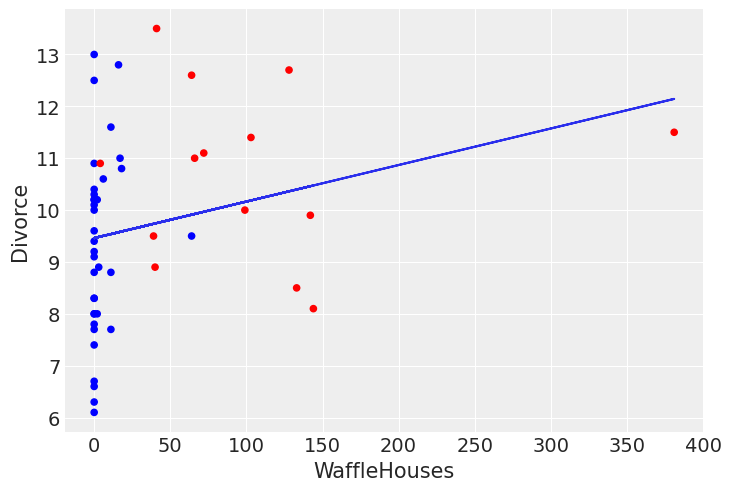

In [4]:
x = df_waf['WaffleHouses']
y = df_waf['Divorce']

colors = df_waf['South'].apply(lambda x: 'r' if x == 1 else 'b')

# Fit the data to a line using polyfit
m, c = np.polyfit(x, y, 1)

# Plot both the line and the original data
_, ax = plt.subplots(1, 1)
ax.plot(x, m * x + c)

df_waf.plot.scatter(x='WaffleHouses', y='Divorce', marker='o', c=colors, ax=ax)

plt.show()

### Code 5.1 Standardize Variables

In [5]:
age = (df_waf['MedianAgeMarriage'] - df_waf['MedianAgeMarriage'].mean()) / df_waf['MedianAgeMarriage'].std()
divorce = (df_waf['Divorce'] - df_waf['Divorce'].mean()) / df_waf['Divorce'].std()
marriage = (df_waf['Marriage'] - df_waf['Marriage'].mean()) /df_waf['Marriage'].std()

## The Model: Divorce Rate vs Median Age

$$
\begin{align*}
    D_i     & \sim N(\mu_i, \sigma) \\
    \mu_i   & \sim \alpha + \beta_A \cdot A_i \\
    \alpha  & \sim N(0, 0.2) \\
    \beta_A & \sim N(0, 0.5) \\
    \sigma  & \sim \text{Exponential}(1)
\end{align*}
$$

In [6]:
np.std(df_waf['Divorce']), np.std(df_waf['MedianAgeMarriage'])

(1.8025138002245642, 1.231131187160816)

### The Priors

Since both $D_i$ and $A_i$ are standardized, we would expect $\alpha \approx 0$. Thus we may use an even smaller standard deviation value than $0.2$ for the prior of $\alpha$. If $\beta_A = 1$, then a one standard deviation change at the median age of marriage results in a change of one standard deviation in the divorce rate. The prior $\beta_A \sim N(0, 0.5)$ places only $5\%$ probability of that happening.    

### Code 5.3

In [7]:
with pm.Model() as m_5_1:
    alpha = pm.Normal('alpha', mu=0, sigma=0.2)
    beta_A = pm.Normal('beta_A', mu=0, sigma=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    
    mu = pm.Deterministic('mu', alpha + beta_A * age)
    D = pm.Normal('divorce', mu=mu, sigma=sigma, observed=divorce)
    
    trace_5_1 = pm.sample(5000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_A, alpha]


Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 14 seconds.


/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


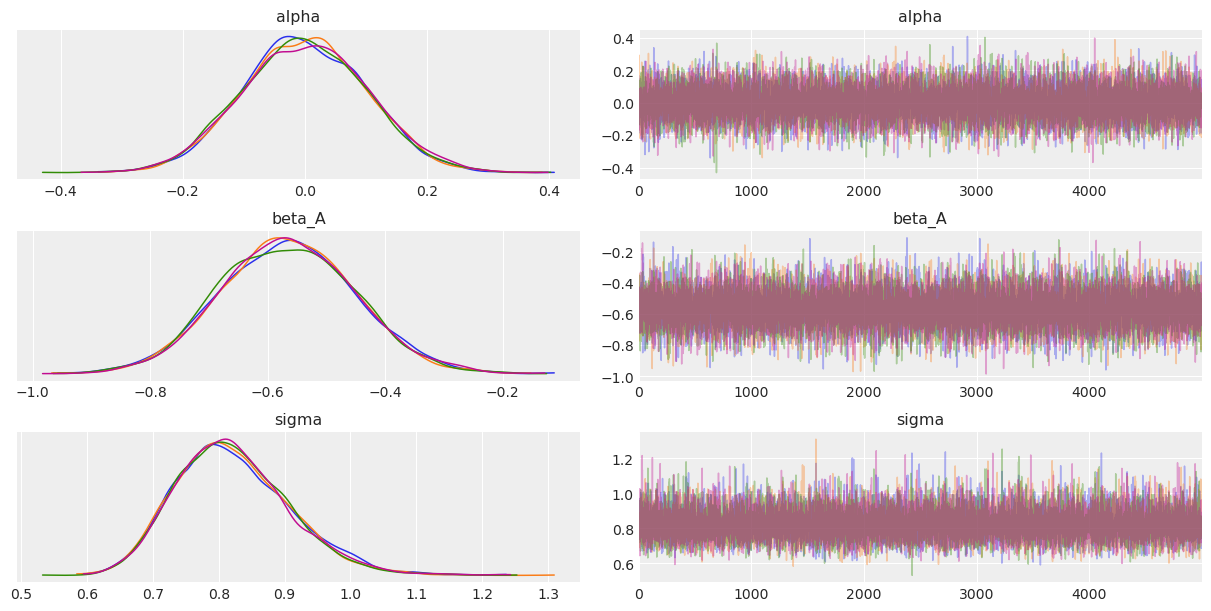

In [8]:
az.plot_trace(trace_5_1, var_names=['alpha', 'beta_A', 'sigma'])

plt.show()

In [9]:
df_trace = pm.trace_to_dataframe(trace_5_1)
df_trace.head()

,alpha,beta_A,sigma,mu__0,mu__1,mu__2,mu__3,mu__4,mu__5,mu__6,...,mu__40,mu__41,mu__42,mu__43,mu__44,mu__45,mu__46,mu__47,mu__48,mu__49
0,0.167446,-0.644163,0.760408,0.557995,0.609792,0.299010,1.075965,-0.218960,0.350807,-0.633336,...,0.402604,0.609792,0.609792,1.593935,-0.270757,-0.011772,0.247213,0.713386,0.040025,1.127762
1,0.167446,-0.644163,0.760408,0.557995,0.609792,0.299010,1.075965,-0.218960,0.350807,-0.633336,...,0.402604,0.609792,0.609792,1.593935,-0.270757,-0.011772,0.247213,0.713386,0.040025,1.127762
2,-0.038539,-0.692584,0.971803,0.381368,0.437058,0.102915,0.938273,-0.453991,0.158605,-0.899515,...,0.214296,0.437058,0.437058,1.495178,-0.509681,-0.231228,0.047224,0.548439,-0.175538,0.993963
3,0.053109,-0.533475,0.737580,0.376549,0.419445,0.162066,0.805514,-0.266900,0.204962,-0.610072,...,0.247859,0.419445,0.419445,1.234480,-0.309796,-0.095314,0.119169,0.505238,-0.052417,0.848411
4,-0.184818,-0.582107,0.861559,0.168107,0.214914,-0.065928,0.636178,-0.533999,-0.019121,-0.908456,...,0.027686,0.214914,0.214914,1.104250,-0.580806,-0.346771,-0.112735,0.308529,-0.299964,0.682986


In [10]:
df_mu = df_trace.filter(regex=('mu.*'))
mu_mean = df_mu.apply(np.mean, axis=0)

In [11]:
mu_mean.values.shape

(50,)

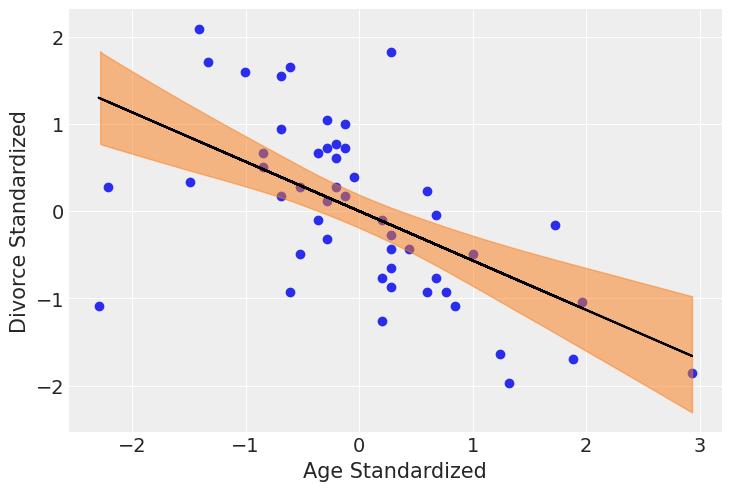

In [12]:
_, ax = plt.subplots(1, 1)
ax.scatter(age, divorce, marker='o')

ax.plot(age, mu_mean, 'k')

az.plot_hdi(age, np.expand_dims(df_mu.values, 0), ax=ax)

ax.set_xlabel('Age Standardized')
ax.set_ylabel('Divorce Standardized')

plt.show()

## Prior Predictive Plots

### Code 5.4

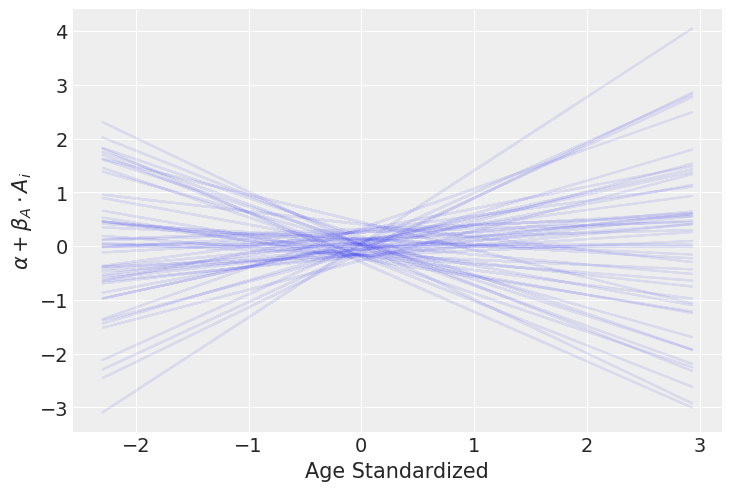

In [13]:
from scipy.stats import norm


N = 50 
alpha_vals = norm.rvs(loc=0, scale=0.2, size=N)
beta_vals = norm.rvs(loc=0, scale=0.5, size=N)

_, ax = plt.subplots(1, 1)
ax.set_xlabel('Age Standardized')
ax.set_ylabel(r'$\alpha + \beta_A \cdot A_i$')

for i in range(N):
    alpha_i = alpha_vals[i]
    beta_i = beta_vals[i]
    
    mu_values = [alpha_i + beta_i * a for a in age]
    
    ax.plot(age, mu_values, color='C0', alpha=0.1)

plt.show()

## Posterior Plots

Since PyMC3 already includes the posterior samples in the trace, we really don't have to do anything more.

### Code 5.5

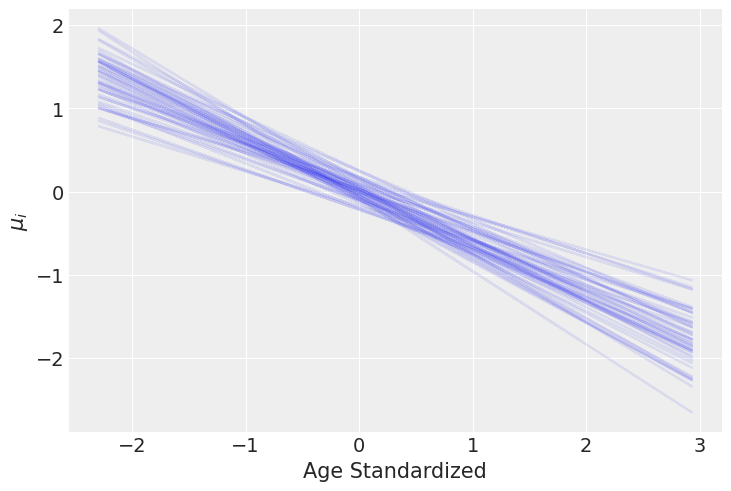

In [14]:
df_mu_T = df_mu.T

sample = np.random.choice(range(0, 20000), size=50)

_, ax = plt.subplots(1, 1)
ax.plot(age, df_mu_T.loc[:, sample], color='C0', alpha=0.1)

ax.set_xlabel('Age Standardized')
ax.set_ylabel(r'$\mu_i$')

plt.show()

## The Model: Divorce Rate vs Marriage Rate

$$
\begin{align*}
    D_i     & \sim N(\mu_i, \sigma) \\
    \mu_i   & \sim \alpha + \beta_M \cdot M_i \\
    \alpha  & \sim N(0, 0.2) \\
    \beta_M & \sim N(0, 0.5) \\
    \sigma  & \sim \text{Exponential}(1)
\end{align*}
$$

### Code 5.6

In [15]:
with pm.Model() as m_5_2:
    alpha = pm.Normal('alpha', mu=0.0, sigma=0.2)
    beta_M = pm.Normal('beta_M', mu=0.0, sigma=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    
    mu = pm.Deterministic('mu', alpha + beta_M * marriage)
    D_2 = pm.Normal('divorce', mu=mu, sigma=sigma, observed=divorce)
    
    trace_5_2 = pm.sample(5000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_M, alpha]


Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 12 seconds.


/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


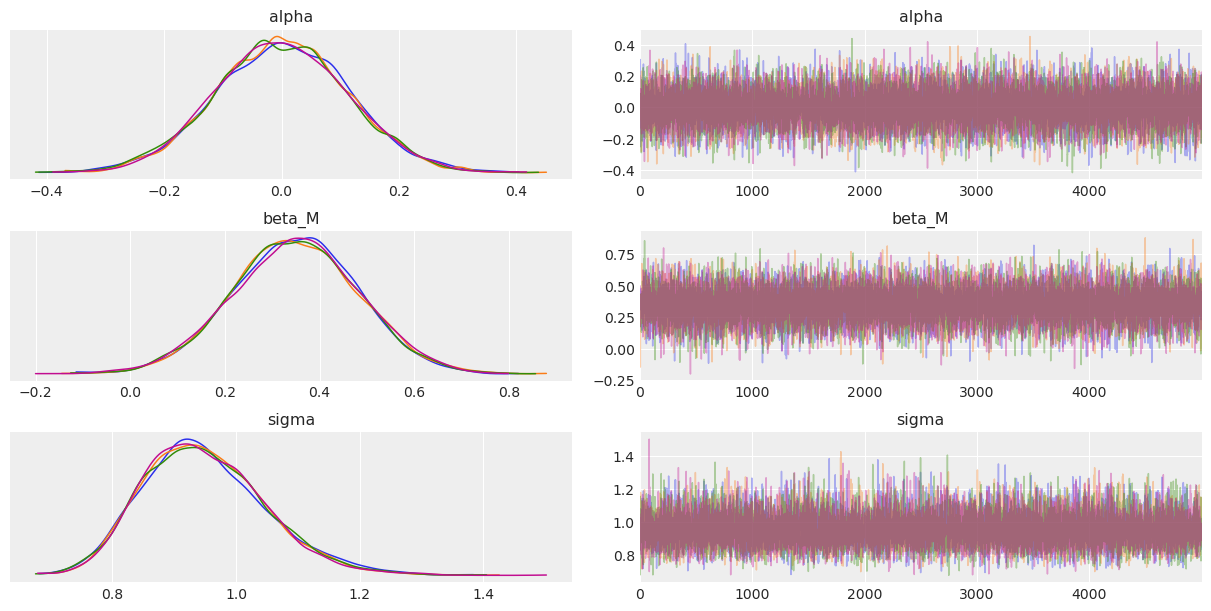

In [16]:
az.plot_trace(trace_5_2, var_names=['alpha', 'beta_M', 'sigma'])

plt.show()

In [17]:
df_tr_2 = pm.trace_to_dataframe(trace_5_2)
df_mu_2 = df_tr_2.filter(regex='(mu.*)')

df_mu_2.head()

,mu__0,mu__1,mu__2,mu__3,mu__4,mu__5,mu__6,mu__7,mu__8,mu__9,...,mu__40,mu__41,mu__42,mu__43,mu__44,mu__45,mu__46,mu__47,mu__48,mu__49
0,0.058179,0.794348,0.070872,0.845118,-0.081439,0.477034,-0.335290,0.426263,-0.259135,-0.347983,...,0.045487,-0.043361,0.223183,1.251280,-0.424138,0.096257,0.210490,0.312030,-0.322597,1.390898
1,-0.001870,0.617818,0.008814,0.660555,-0.119397,0.350711,-0.333083,0.307974,-0.268977,-0.343767,...,-0.012554,-0.087344,0.137026,1.002452,-0.407873,0.030183,0.126341,0.211816,-0.322398,1.119979
2,-0.125007,0.371273,-0.116450,0.405499,-0.219129,0.157359,-0.390260,0.123133,-0.338921,-0.398817,...,-0.133564,-0.193459,-0.013772,0.679309,-0.450156,-0.099337,-0.022328,0.046124,-0.381704,0.773431
3,0.251951,0.972444,0.264374,1.022133,0.115306,0.661887,-0.133139,0.612198,-0.058606,-0.145562,...,0.239529,0.152573,0.413441,1.419646,-0.220095,0.289218,0.401019,0.500397,-0.120717,1.556291
4,0.311656,0.819304,0.320408,0.854314,0.215377,0.600490,0.040326,0.565480,0.092842,0.031574,...,0.302903,0.241635,0.425439,1.134395,-0.020941,0.337913,0.416686,0.486707,0.049079,1.230674


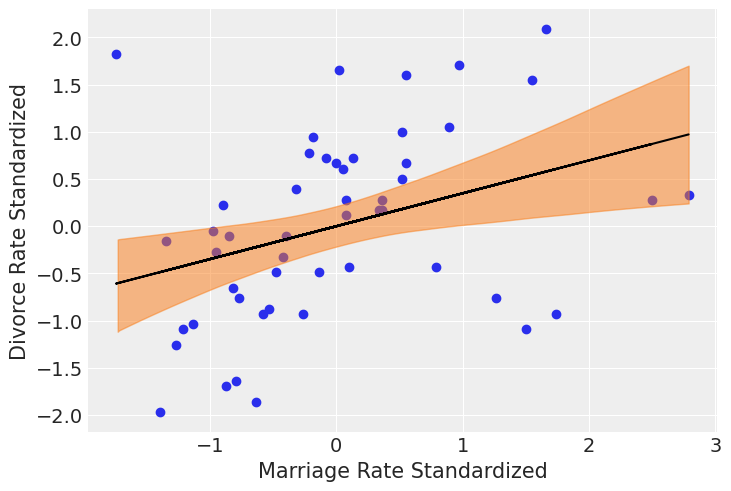

In [18]:
mu_mean_2 = df_mu_2.apply(np.mean, axis=0)

_, ax = plt.subplots(1, 1)
ax.scatter(marriage, divorce, marker='o')

ax.plot(marriage, mu_mean_2, 'k')

az.plot_hdi(marriage, np.expand_dims(df_mu_2.values, 0), ax=ax)

ax.set_xlabel('Marriage Rate Standardized')
ax.set_ylabel('Divorce Rate Standardized')

plt.show()